In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random
from matplotlib import pyplot as plt
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from models import SciNet
import pandas as pd
from utils import target_loss 
from loader import build_dataloader
import torch.optim.lr_scheduler as lr_scheduler
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

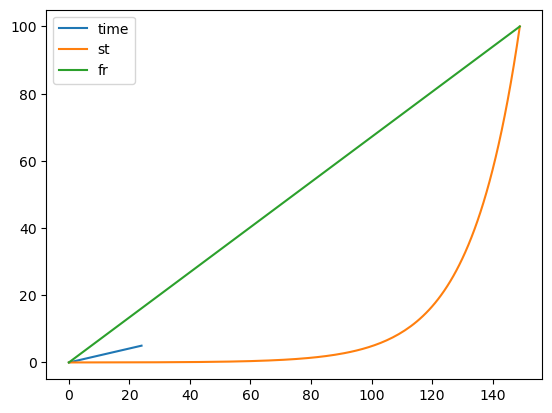

In [2]:
size = 25
size_ = 150
t_max = 5
t = np.linspace(0, t_max, size)
min_fr, max_fr = 0.01, 100
fr = np.linspace(min_fr, max_fr, size_)
start_st, end_st = 0.01, 100
st = np.logspace(np.log10(start_st), np.log10(end_st), size_, endpoint = True)

plt.plot(t, label="time")
plt.plot(st, label="st")
plt.plot(fr, label="fr")
plt.legend()

In [3]:
# the function that we generate the data with
def f(t, st, fr):
    return st**2 * fr * (1 - t/st - np.exp(-t/st))
'''def f(t, st, fr):
    return  st + fr + t'''
data = []
for st_ in st:
    for fr_ in fr:
        example = list(f(t, st_, fr_))
        t_pred = np.random.uniform(0, t_max)
        pred = f(t_pred,st_,fr_)
        example.append(fr_)
        example.append(st_)
        example.append(t_pred)
        example.append(pred)
        data.append(example)
data = np.array(data)
colummns = [str(i) for i in range(size)]
colummns.append("fr")
colummns.append("st")
colummns.append("t_pred")
colummns.append("pred") 
df = pd.DataFrame(data,columns=colummns)
df.to_csv("data.csv")
df.shape

(22500, 29)

In [4]:
# Setup scinet model with 3 latent neurons
scinet = SciNet(size,1,3,100)

# Load and prepare training data
dataloader = build_dataloader(size=size, batch_size =100)

# Training setup
N_EPOCHS = 200
SAVE_PATH = f"trained_models/scinet1-{size}epoch{N_EPOCHS}.dat"
optimizer = optim.Adam(scinet.parameters(), lr=0.001)
hist_error = []
hist_kl = []
hist_loss = []
scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.009, total_iters=N_EPOCHS)
beta = 0.5

# Training loop
for epoch in range(N_EPOCHS):  
    epoch_error = []
    epoch_kl = []
    epoch_loss = []
    for i_batch, minibatch in enumerate(dataloader):
        time_series, _, _, question, answer = minibatch['time_series'] / 5, minibatch['fr'] / 5, minibatch['st'] / 5, minibatch['question'] / 5, minibatch['answer'] / 5
        # concat the time series with the features
        inputs = torch.cat((time_series, question.reshape(-1, 1)), 1)
        # build the output
        outputs = answer

        optimizer.zero_grad()
        # print(inputs[0])
        pred = scinet.forward(inputs)
        # print(pred)
        # break
        loss_ = target_loss(pred, outputs)
        kl = beta * scinet.kl_loss
        loss = loss_ + kl
        loss.backward()
        optimizer.step()
        error = torch.mean(torch.sqrt((pred[:,0]-outputs)**2)).detach().numpy()
        epoch_error.append(error)
        epoch_kl.append(kl.data.detach().numpy())
        epoch_loss.append(loss_.data.detach().numpy())
    # break
    hist_error.append(np.mean(epoch_error))
    hist_loss.append(np.mean(epoch_loss))
    hist_kl.append(np.mean(epoch_kl))

    before_lr = optimizer.param_groups[0]["lr"]
    scheduler.step()
    after_lr = optimizer.param_groups[0]["lr"]
    print("Epoch %d: SGD lr %.6f -> %.6f" % (epoch+1, before_lr, after_lr))
    
    print("Epoch %d -- loss %f, RMS error %f, KL %f" % (epoch+1, hist_loss[-1], hist_error[-1], hist_kl[-1]))
torch.save(scinet.state_dict(), SAVE_PATH)
print("Model saved to %s" % SAVE_PATH)

Epoch 1: SGD lr 0.001000 -> 0.000995
Epoch 1 -- loss 78082.718750, RMS error 14.851391, KL 185469.062500
Epoch 2: SGD lr 0.000995 -> 0.000990
Epoch 2 -- loss 75781.546875, RMS error 14.871805, KL 243.088074
Epoch 3: SGD lr 0.000990 -> 0.000985
Epoch 3 -- loss 73181.523438, RMS error 15.143744, KL 204.925629
Epoch 4: SGD lr 0.000985 -> 0.000980
Epoch 4 -- loss 68641.507812, RMS error 15.441910, KL 920.740479
Epoch 5: SGD lr 0.000980 -> 0.000975
Epoch 5 -- loss 52737.148438, RMS error 13.670547, KL 1040.348022
Epoch 6: SGD lr 0.000975 -> 0.000970
Epoch 6 -- loss 30241.158203, RMS error 9.580770, KL 340.340668
Epoch 7: SGD lr 0.000970 -> 0.000965
Epoch 7 -- loss 10707.455078, RMS error 5.363183, KL 211.287766
Epoch 8: SGD lr 0.000965 -> 0.000960
Epoch 8 -- loss 4699.089355, RMS error 3.482183, KL 215.069550
Epoch 9: SGD lr 0.000960 -> 0.000955
Epoch 9 -- loss 3077.264404, RMS error 2.775081, KL 193.371124
Epoch 10: SGD lr 0.000955 -> 0.000950
Epoch 10 -- loss 1765.507080, RMS error 2.0272

NameError: name 'epochs' is not defined

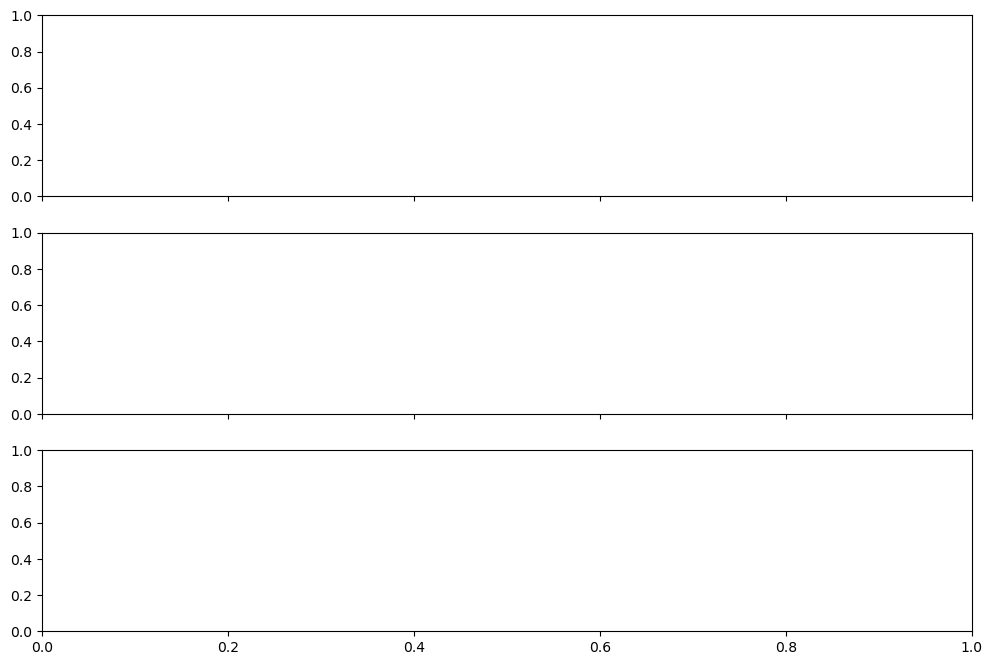

In [5]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Create a figure with three subplots
fig, axs = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

# Define the starting epoch for zooming in
start_epoch = 150  # Change this to your desired starting epoch
end_epoch = N_EPOCHS  # Change this to your desired ending epoch

# Plot the first subplot
axs[0].plot(epochs, hist_kl)
axs[0].set_ylabel("KL Divergence", fontsize=16, fontweight='bold')
axs[0].grid(True)

# Create an inset_axes for zooming in on the first subplotss
axins1 = inset_axes(axs[0], width="35%", height="35%", loc='upper right')
axins1.plot(epochs[start_epoch:end_epoch], hist_kl[start_epoch:end_epoch])
axins1.grid(True)

# Add a thinner, black rectangle with smaller height to the initial plot indicating the zoomed-in area
rect1 = Rectangle((start_epoch, min(hist_kl)), end_epoch - start_epoch, (max(hist_kl) - min(hist_kl)) / 4, fill=False, edgecolor='black', linewidth=1)
axs[0].add_patch(rect1)

# Plot the second subplot
axs[1].plot(epochs, hist_error)
axs[1].set_ylabel("RMSE", fontsize=16, fontweight='bold')
axs[1].grid(True)

# Create an inset_axes for zooming in on the second subplot
axins2 = inset_axes(axs[1], width="35%", height="35%", loc='upper right')
axins2.plot(epochs[start_epoch:end_epoch], hist_error[start_epoch:end_epoch])
axins2.grid(True)

# Add a thinner, black rectangle with smaller height to the initial plot indicating the zoomed-in area
rect2 = Rectangle((start_epoch, min(hist_error)), end_epoch - start_epoch, (max(hist_error) - min(hist_error)) / 4, fill=False, edgecolor='black', linewidth=1)
axs[1].add_patch(rect2)

# Plot the third subplot
axs[2].plot(epochs, hist_loss)
axs[2].set_xlabel("Epoch", fontsize=16, fontweight='bold')
axs[2].set_ylabel("Loss", fontsize=16, fontweight='bold')
axs[2].grid(True)

# Create an inset_axes for zooming in on the third subplot
axins3 = inset_axes(axs[2], width="35%", height="35%", loc='upper right')
axins3.plot(epochs[start_epoch:end_epoch], hist_loss[start_epoch:end_epoch])
axins3.grid(True)

# Add a thinner, black rectangle with smaller height to the initial plot indicating the zoomed-in area
rect3 = Rectangle((start_epoch, min(hist_loss)), end_epoch - start_epoch, (max(hist_loss) - min(hist_loss)) / 4, fill=False, edgecolor='black', linewidth=1)
axs[2].add_patch(rect3)

# Adjust layout
plt.tight_layout()

# Save the plot as 'loss_zoomed_with_rectangles.pdf'
plt.savefig(f'plot/loss_zoomed_with_rectangles_{size}size_{N_EPOCHS}epoch.pdf')

# Show the plot (optional)
plt.show()
